In [1]:
%load_ext autoreload
%autoreload true

In [2]:
import sys
sys.path.insert(0, '../..')

import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score

from utils import DataManager
from Substation import *

# Instantiation of the best model

In [3]:
from sklearn.decomposition import PCA

scaler = PCA(n_components=7, whiten=True)

In [7]:
from xgboost import XGBClassifier

# Best model from hyper optimisation
model = XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.6687862669596467, colsample_bynode=1,
              colsample_bytree=0.9491625166168192, enable_categorical=False,
              gamma=0.05097107519129084, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.3291657170433937,
              max_delta_step=0, max_depth=8, min_child_weight=6, 
              monotone_constraints='()', n_estimators=1600, n_jobs=20,
              num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=4.520676601180023e-05, reg_lambda=2.761350359143646,
              scale_pos_weight=1, seed=1, subsample=0.974766816238674,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

# Loading train data and training model

In [8]:
from load_fault_dataset import SubstationFaultLoader

loader = SubstationFaultLoader(os.path.join(DATA_ROOT, 'Substation-20221015'))

train_faults = pd.read_csv(TRAIN_SPEC, index_col=0)
data_train, metadata_train = loader.load_fault_dataset_df(list(train_faults.index.values))
dm_train = DataManager()
dm_train.prepare_database(data_train, metadata_train, del_cols=HIDDEN_VARS+['anomaly'])

X_train, y_train = dm_train.split_X_Y_concat()

In [9]:
scaler.fit(X_train)

PCA(n_components=7, whiten=True)

In [10]:
model.fit(scaler.transform(X_train), y_train)

[18:14:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.6687862669596467, colsample_bynode=1,
              colsample_bytree=0.9491625166168192, enable_categorical=False,
              gamma=0.05097107519129084, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.3291657170433937,
              max_delta_step=0, max_depth=8, min_child_weight=6, missing=nan,
              monotone_constraints='()', n_estimators=1600, n_jobs=20,
              num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=4.520676601180023e-05, reg_lambda=2.761350359143646,
              scale_pos_weight=1, seed=1, subsample=0.974766816238674,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

# Load test data and computing predictions

In [16]:
test_faults = pd.read_csv(TEST_SPEC, index_col=0)
data_test , metadata_test = loader.load_fault_dataset_df(list(test_faults.index.values))
dm_test = DataManager()
dm_test.prepare_database(data_test, metadata_test, del_cols=HIDDEN_VARS+['anomaly'])

X_test, y_test = dm_test.split_X_Y_concat()

y_pred = model.predict(scaler.transform(X_test))

# Computing model scores

In [17]:
mcc = matthews_corrcoef(y_test,	y_pred)
print("MCC: %.3f" % mcc)

acc = accuracy_score(y_test, y_pred)
print("Accuracy: %.3f" % acc)

MCC: 0.827
Accuracy: 0.912


# Plotting sample results

In [18]:
X_test_plot, y_test_plot = dm_test.split_X_Y()

for p in y_test_plot:
    p.index = pd.TimedeltaIndex(300 * p.index, unit='s')


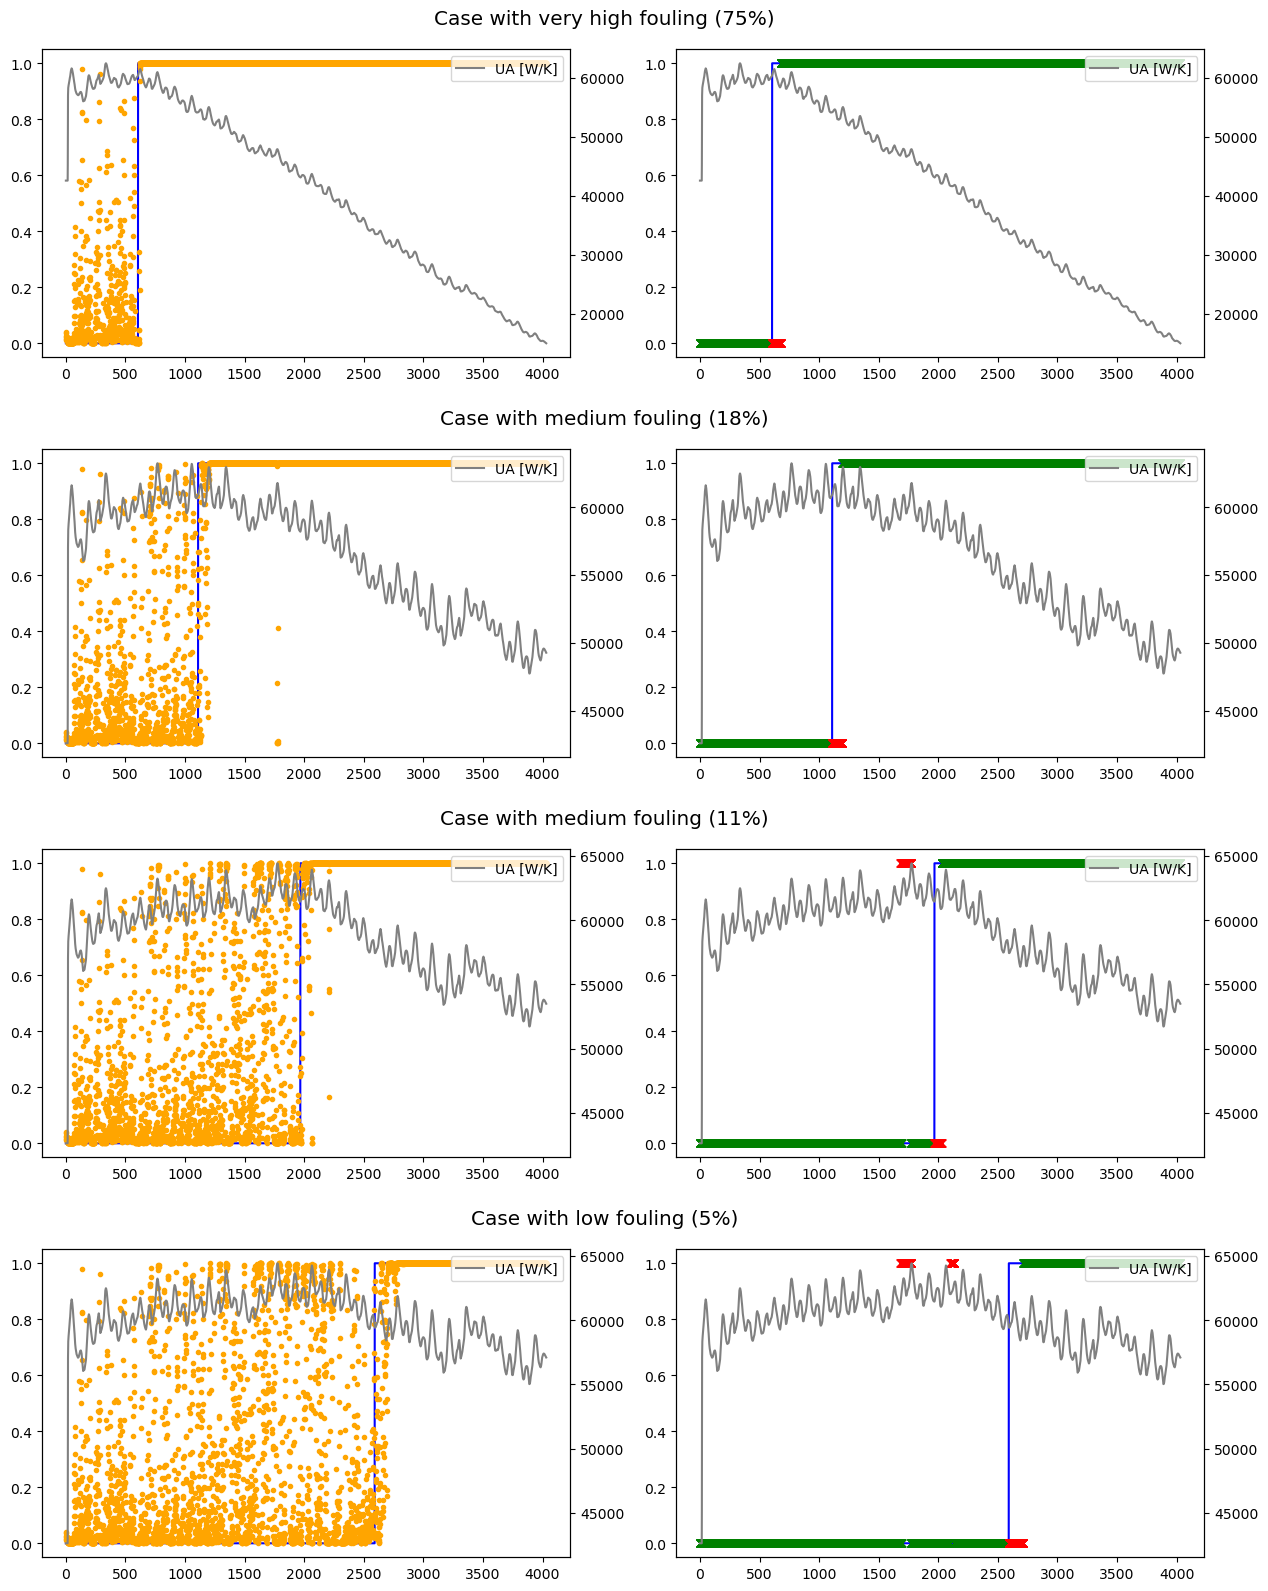

In [27]:
from Yacine.model_evaluation_plots import *

fault_var = 'UA'
fault_var_label = 'UA [W/K]'

test_ids = [7,2,5,6]
titles = [
    'Case with very high fouling (75%)',
    'Case with medium fouling (18%)',
    'Case with medium fouling (11%)',
    'Case with low fouling (5%)',
]

nb_test = len(test_ids)
#fig, ax = plt.subplots(nb_test, 2, figsize=(25,6*nb_test))
fig = plt.figure(figsize=(15,4*nb_test))

subfigs = fig.subfigures(nrows=nb_test, ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(titles[row], fontsize='x-large')
    ax = subfig.subplots(nrows=1, ncols=2)

    ii = test_ids[row]
    y_data = y_test_plot[ii].values.astype(np.float64)
    y_prob = model.predict_proba(scaler.transform(X_test_plot[ii]))[:,1]
    y_pred = alert_trigger(horizon=144, proba=y_prob, threshold=0.5)
    # y_pred = model.predict(scaler.transform(X_test_plot[ii]))
    fault_var_data = dm_test.del_cols_data[ii][fault_var].values.astype(np.float64)

    plot_proba(ax[0], y_data, y_prob, fault_var_label, fault_var_data)
    plot_true_false(ax[1], y_data, y_pred, fault_var_label, fault_var_data) 